In [6]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

# Загружаем датасет

In [7]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

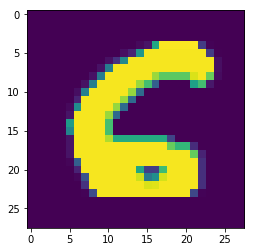

In [8]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][2].reshape(28,28))

In [9]:
train

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'labels': array([5., 5., 6., ..., 6., 5., 6.])}

# Обучаем модель

In [10]:
#softmax loss + gradient
def softmaxLoss(W, X, y, reg):
    loss = 0.0
    dW = np.zeros_like(W)
    numberOfElements = X.shape[0]
    numberOfClasses = W.shape[1]
    fullScore = X.dot(W)
    fullScore -= np.max(fullScore)
  
    fullScore = np.exp(fullScore)
    fullScore = np.array([row / np.sum(row) for row in fullScore])
  
    loss -= np.mean(np.log(fullScore[np.arange(fullScore.shape[0]), y]))
  
    coefs = fullScore
    
    coefs[np.arange(coefs.shape[0]), y] -= 1
  
    dW = np.dot(X.T, coefs)

    dW /= numberOfElements
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg * W

    return loss, dW

In [11]:
def adam(w, dw, config=None):
    
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)  #grad
    config.setdefault('beta2', 0.999) #grad grad
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    next_w = None
    
    t = config['t'] + 1
    m = config['beta1'] * config['m'] + (1 - config['beta1']) * dw
    mt = m / (1 - config['beta1']**t)
    v = config['beta2'] * config['v'] + (1 - config['beta2']) * (dw**2)
    vt = v / (1 - config['beta2']**t)
    next_w = w - config['learning_rate'] * mt / (np.sqrt(vt) + config['epsilon'])
    config['t'] = t
    config['m'] = m
    config['v'] = v

    return next_w, config

In [41]:
class LinearClassifier(object):
    def __init__(self):
        self.W = None
        self.Wbest = None
        self.lossMin = 1000

    def train(self, trainData, trainLabels, valData, valLabels, learningRate=1e-7, reg=1, numIters=10000, batchSize=200, verbose=True):
        numTrain, vectorSize = trainData.shape
        numClasses = np.max(labels) + 1
        if self.W is None:
            #self.W = np.random.normal(scale=1, size=(numClasses, vectorSize)) * np.sqrt(2/(numClasses + vectorSize))
            self.W = 0.0001 * np.random.randn(vectorSize, numClasses)

        lossHistoryTrain = {}
        lossHistoryVal = {}
        accHistoryTrain = {}
        accHistoryVal = {} 
        config = {"learning_rate" : learningRate}
        for it in range(numIters):
            batchIndicies = np.random.choice(numTrain, batchSize)
            X_batch = trainData[batchIndicies]
            y_batch = trainLabels[batchIndicies]
            trainLoss, grad = self.loss(X_batch, y_batch, reg)
            lossHistoryTrain[it] = trainLoss
            self.W, config = adam(self.W, grad, config)
                
            if verbose and it % (numIters/ 20) == 0:
                valLoss, _ = self.loss(valData, valLabels, reg)
                lossHistoryVal[it] = valLoss
                accHistoryTrain[it] = self.accuracy(X_batch, y_batch)
                accHistoryVal[it] = self.accuracy(valData, valLabels)
                print('iteration %d / %d: train loss %f val loss %f' % (it, numIters, trainLoss, valLoss))
                
                if valLoss < self.lossMin:
                    self.Wbest = np.copy(self.W)
                    self.lossMin = valLoss
                    print("new best loss - ", valLoss)
                
            if  it % (numIters / 20) == 0:
                config["learning_rate"] *= 0.95
                
                
        return lossHistoryTrain, lossHistoryVal, accHistoryTrain, accHistoryVal

    def predict(self, data):
        y_pred = np.zeros(data.shape[0])
        scores = data.dot(self.W)
        y_pred = [np.argmax(x) for x in scores]
        return y_pred
    
    def loss(self, X_batch, y_batch, reg):
        return softmaxLoss(self.W, X_batch, y_batch, reg)
    
    def accuracy(self, data, labels):
        return (self.predict(data) == labels).mean()
    
    def scores(self, data):
        fullScore = data.dot(self.Wbest)
        fullScore -= np.max(fullScore)
        fullScore = np.exp(fullScore)
        fullScore = np.array([row / np.sum(row) for row in fullScore])
        return fullScore

    


In [43]:
reg = 1e-2
learningRate = 1e-7
splitFactor = 8500
numIters= 200000

model = LinearClassifier()
# 5 - 0, 6 - 1
labels =  np.array([int(x) for x in train["labels"]])
labels[labels == 5] = 0
labels[labels == 6] = 1
trainLabels = labels[:splitFactor:]
valLabels = labels[splitFactor::]

myTrain = np.array(train["data"])[:splitFactor:]
myVal = np.array(train["data"])[splitFactor::]


lossHistoryTrain, lossHistoryVal, accHistoryTrain, accHistoryVal = model.train(myTrain, trainLabels, myVal, valLabels, learningRate,
                                                                               reg,numIters)

trainAccuracy = (model.predict(myTrain) == trainLabels).mean()
valAccuracy = (model.predict(myVal) == valLabels).mean()
print(trainAccuracy)
print(valAccuracy)


iteration 0 / 200000: train loss 0.717596 val loss 0.719938
new best loss -  0.7199379046609193
iteration 10000 / 200000: train loss 0.057179 val loss 0.070816
new best loss -  0.07081562335939201
iteration 20000 / 200000: train loss 0.035671 val loss 0.057155
new best loss -  0.057154616414732816
iteration 30000 / 200000: train loss 0.050455 val loss 0.052789
new best loss -  0.05278920712790789
iteration 40000 / 200000: train loss 0.054743 val loss 0.050622
new best loss -  0.05062180727301422
iteration 50000 / 200000: train loss 0.045190 val loss 0.049642
new best loss -  0.049642493964569746
iteration 60000 / 200000: train loss 0.043452 val loss 0.049055
new best loss -  0.04905485822134503
iteration 70000 / 200000: train loss 0.027473 val loss 0.048735
new best loss -  0.04873535728966505
iteration 80000 / 200000: train loss 0.070352 val loss 0.048826
iteration 90000 / 200000: train loss 0.041160 val loss 0.049082
iteration 100000 / 200000: train loss 0.038880 val loss 0.049103
it

In [44]:
X = test_no_lables['data']
scores = model.scores(X)

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(X)):
        print(i, scores[i][1], sep=',', file=fout)

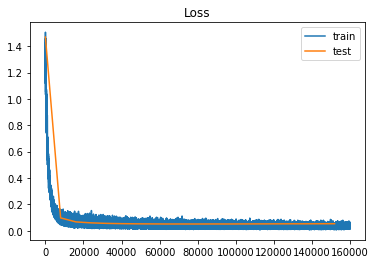

In [28]:
plt.title('Loss')
plt.plot(lossHistoryTrain.keys(), lossHistoryTrain.values(), label='train')
plt.plot(lossHistoryVal.keys(), lossHistoryVal.values(), label='test')
plt.legend()

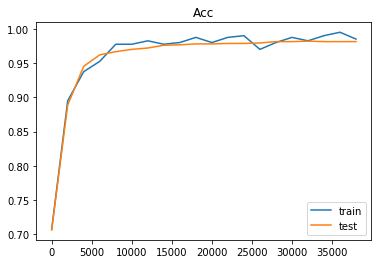

In [20]:
plt.title('Acc')
plt.plot(accHistoryTrain.keys(), accHistoryTrain.values(), label='train')
plt.plot(accHistoryVal.keys(), accHistoryVal.values(), label='test')
plt.legend()

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

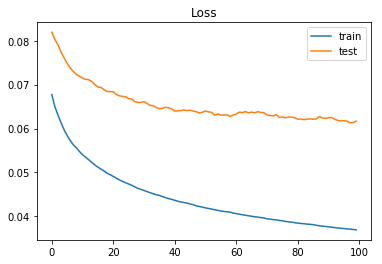

In [219]:
plt.title('Loss')
plt.plot([e[0] for e in tr_eval], label='train')
plt.plot([e[0] for e in te_eval], label='test')
plt.legend()

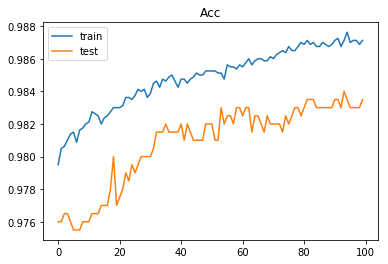

In [220]:
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend()

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [221]:
X = test_no_lables['data']

# compute Y_pred

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(test['labels'])):
        print(i, Y_pred[i], sep=',', file=fout)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Пишите тему письм в формате "[МИФИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем family.ipynb
- Обязательно указывайте ваш ник на kaggle